# Imports

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz

# Importing the Dataset

In [2]:
raw_df = pd.read_csv('../raw_data/data_for_first_model.csv')
df = raw_df.copy()
df

,garage,price,rooms,sqm
0,1,330000,1,40
1,5,1190000,4,411
2,4,1590000,4,158
3,6,550000,3,278
4,1,450000,3,87
...,...,...,...,...
5729,2,560000,3,92
5730,1,440000,3,90
5731,2,500000,3,80
5732,2,740000,3,80


# Scaling the Data

## Checking the Data's Distribution

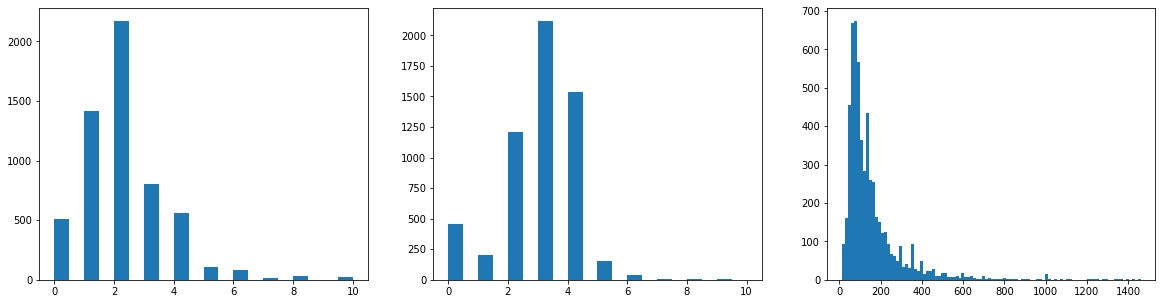

In [3]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.hist(df['garage'], bins = 20);
plt.subplot(1,3,2)
plt.hist(df['rooms'], bins = 20);
plt.subplot(1,3,3)
plt.hist(df['sqm'], bins = 100);

Non-Gaussian and without outliers: the best scaler in this scenario is the **MIN MAX SCALER**.

## Applying the MinMax Scaler

In [4]:
scaler = MinMaxScaler().fit(df[['sqm', 'garage', 'rooms']])
df[['sqm', 'garage', 'rooms']] = scaler.transform(df[['sqm', 'garage', 'rooms']])
df

,garage,price,rooms,sqm
0,0.1,330000,0.1,0.017981
1,0.5,1190000,0.4,0.274550
2,0.4,1590000,0.4,0.099585
3,0.6,550000,0.3,0.182573
4,0.1,450000,0.3,0.050484
...,...,...,...,...
5729,0.2,560000,0.3,0.053942
5730,0.1,440000,0.3,0.052559
5731,0.2,500000,0.3,0.045643
5732,0.2,740000,0.3,0.045643


# Defining the Train and Test set

## Defining X and Y

In [5]:
y = df['price']
X = df[['garage', 'sqm']]

## Splitting the Sets

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Structuring the Model

## Baseline Model/Dummy Model

In [7]:
baseline_model = DummyRegressor()
baseline_model.fit(X_train, y_train)
score = baseline_model.score(X_test, y_test)
score

-0.002207867522849849

That's a **terrible** (but expected) result.

## Linear Regression

In [8]:
model = LinearRegression()
cv_results = cross_validate(model, X_train, y_train, cv=5, scoring='r2')
cv_results['test_score'].mean()

0.5051955901588716

**0.50**? Better than the Baseline Model, but it's just like throwing a coin!

**IMPORTANT**: I tried the model using the **rooms** feature, and the score was 0.48, which proves the statistical approach of the last notebook.

## Checking the Learning Curves

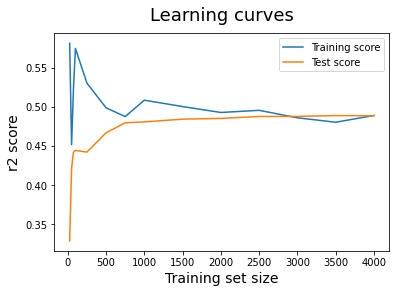

In [9]:
#Define our Train Sizes inside the function, or store it outside in a variable just like you did here;
train_sizes = [25,50,75,100,250,500,750,1000,1500,2000,2500,3000,3500,4000]

        #The function output consists in 5 arrays: train_sizes_abs, train_scores, test_scores, fit_times and score_times;
        #The function performs an Automatic Cross Validation (again, the 'cv' is the number of folds);
        #The 'estimator' must be an object that can perform both 'fit' and 'test' methods;
train_sizes, train_scores, test_scores = learning_curve(estimator=LinearRegression(), X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2')

        #Compute the mean of the Cross-Validated Train Scores and Test Scores;
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

        #And now plot the whole thing;
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

At least the model doesn't seem to be under/over-fitting.

## Checking the Residuals

In [10]:
#Instantiating and trainning a model;
model = LinearRegression().fit(X_train, y_train)
#Predicting house prices with the model;
predictions = model.predict(X_test)
#Checking the difference between the predictions and the real prices
residuals = y_test - predictions

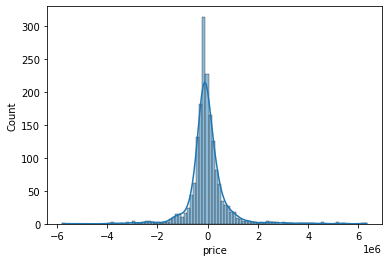

In [11]:
sns.histplot(residuals, bins=100, kde=True);

We can clearly see a Gaussian distribution centered (apparently) on zero. That's a good start, however, we do have some considerable residual episodes from a model with a R² Score of 0.5. That's not the best result ever. Maybe, considering location as a feature might help us improve the model's score/predictions.

## Decision Tree

Let's use a **Gridsearch** to check the best params for our tree.

In [12]:
tree = DecisionTreeRegressor()

grid = {'max_depth': [4, 5, 6], 
        'min_samples_split': [2, 3, 4],
        'min_samples_leaf': [10, 20, 30]}

search = GridSearchCV(tree, grid, 
                           scoring = 'r2',
                           cv = 5,
                           n_jobs=-1 # paralellize computation
                          )

search.fit(X_train, y_train)
print(search.best_score_, search.best_params_) # >>> 0.4946606248693768 {'max_depth': 5, 'min_samples_leaf': 20, 'min_samples_split': 2}

0.5115823476043 {'max_depth': 5, 'min_samples_leaf': 30, 'min_samples_split': 2}


In [13]:
tree = DecisionTreeRegressor(max_depth=5, min_samples_split=2, min_samples_leaf=20)

cv_results = cross_validate(tree, X, y, scoring = "r2", cv=5)
cv_results['test_score'].mean() # >>> 0.48934849338527975

0.48934849338527975

Let's check the **Learning Curves** as well, to make sure our model is not under/over-fitting.

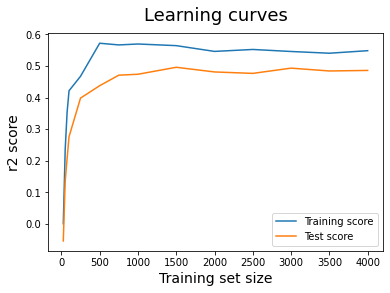

In [14]:
#Define our Train Sizes inside the function, or store it outside in a variable just like you did here;
train_sizes = [25,50,75,100,250,500,750,1000,1500,2000,2500,3000,3500,4000]

        #The function output consists in 5 arrays: train_sizes_abs, train_scores, test_scores, fit_times and score_times;
        #The function performs an Automatic Cross Validation (again, the 'cv' is the number of folds);
        #The 'estimator' must be an object that can perform both 'fit' and 'test' methods;
train_sizes, train_scores, test_scores = learning_curve(DecisionTreeRegressor(max_depth=5, 
                                                                              min_samples_split=2, 
                                                                              min_samples_leaf=20), X=X, y=y, train_sizes=train_sizes, cv=5, scoring='r2')

        #Compute the mean of the Cross-Validated Train Scores and Test Scores;
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

        #And now plot the whole thing;
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend()

Seems ok! Let's now visualize the structure of our tree!

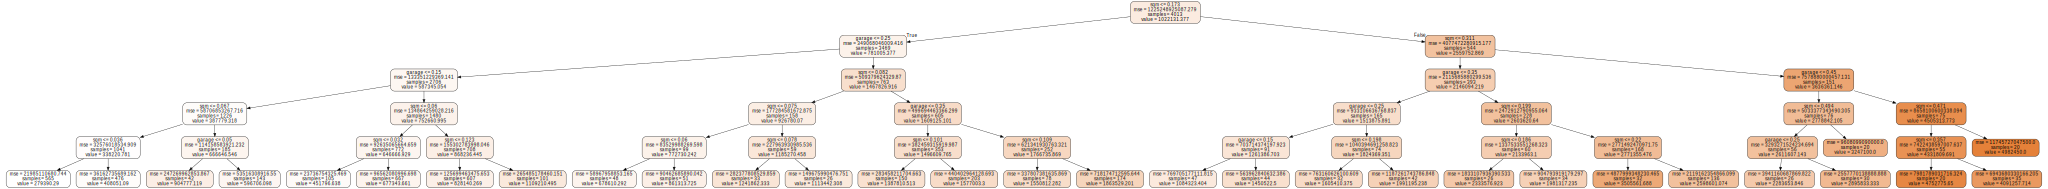

In [15]:
tree.fit(X_train, y_train)

export_graphviz(tree, out_file="housing.dot", 
                feature_names=df[['garage', 'sqm']].columns,
                class_names=['0','1','2'], 
                rounded=True, filled=True)

with open("housing.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Random Forest

Since the score still low, let's try modeling with a bunch of Trees.

In [16]:
forest = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_split=2, min_samples_leaf=5)

cv_results = cross_validate(forest, X, y, scoring = "r2", cv=5)
cv_results['test_score'].mean()

0.5058669364529811

Didn't improve that much.

Maybe this is a sign that we are dealing with a small number of occurrences, or maybe our features are not that correlated with our target.

In a future step, let's try to consider the region in which the houses are located to compute how the price might change.